In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
import time
import os

# proxyの設定．
# torchvision.datasetsを利用する場合は，datasetを直接ダウンロードするので，学内マシンからは通常必要．
os.environ["http_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["https_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"      # "0":GPU0, "1":GPU1, "0,1":GPUを2つとも使用

import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

In [2]:
import torchvision.models as models
from PIL import Image
import torchvision.transforms as transforms
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [83]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2, return_indices=True)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.deconv2 = nn.ConvTranspose2d(16, 6, 5)
        self.unpool = nn.MaxUnpool2d(2, stride=2)
        self.deconv1 = nn.ConvTranspose2d(6, 3, 5) 

    def forward(self, x):
        x, indices1= self.pool(F.relu(self.conv1(x)))
        x, indices2= self.pool(F.relu(self.conv2(x)))
        x = self.unpool(x, indices2)
        x = self.unpool(F.relu(self.deconv2(x)), indices1)
        x = self.deconv1(x)
        return x

autoencoder = Net()

In [84]:
autoencoder

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (deconv2): ConvTranspose2d(16, 6, kernel_size=(5, 5), stride=(1, 1))
  (unpool): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (deconv1): ConvTranspose2d(6, 3, kernel_size=(5, 5), stride=(1, 1))
)

In [85]:
from torchvision import datasets, transforms
def imshow(img):
    npimg = img.cpu().numpy()   
    reverse_mean = [-0.4914, -0.4822, -0.4465]
    reverse_std = [1/0.2023, 1/0.1994, 1/0.2010]
    recreated_im = npimg
    for c in range(3):
        recreated_im[c] /= reverse_std[c]
        recreated_im[c] -= reverse_mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)
    recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
    return recreated_im

image_size = (128, 128) 
normalize = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
#normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
transform = transforms.Compose([transforms.Resize(image_size),transforms.ToTensor(),normalize])

img = Image.open('cat.jpg')
img = transform(img)
img = img.unsqueeze(0)

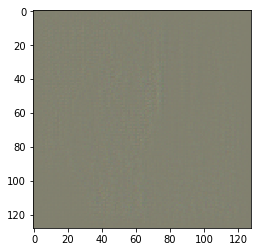

In [86]:
autoencoder.eval() 
with torch.no_grad():
    out=autoencoder(img)

out = out.reshape((3,128,128))
outim = imshow(out)
plt.imshow(outim)
plt.show()

In [80]:
#cifar10を使用
#dataset load
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [88]:
#lossとoptimizerを定義
import torch.optim as optim
autoencoder = nn.DataParallel(autoencoder)
autoencoder = autoencoder.to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(autoencoder.parameters(), lr=0.001, momentum=0.9)

In [89]:
torch.cuda.synchronize()
start = time.time()
autoencoder.train()
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.cuda()
        #labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # print statistics
    print('[%d] loss: %.3f' %
          (epoch + 1, running_loss / i))
    running_loss = 0.0

    if (epoch+1) % 5 == 0:
        with torch.no_grad():
            out=autoencoder(img)
        out = out.reshape((3,128,128))
        out = imshow(out)
        outim = Image.fromarray(np.uint8(out))
        name = "result/" + str(epoch+1) + '.jpg'
        outim.save(name)
        
torch.cuda.synchronize()
end = time.time()
print('Finished Training')
print("Time: %1.4f" % (end - start))

[1] loss: 1.224
[2] loss: 0.774
[3] loss: 0.693
[4] loss: 0.656
[5] loss: 0.628
[6] loss: 0.600
[7] loss: 0.566
[8] loss: 0.520
[9] loss: 0.473
[10] loss: 0.410
[11] loss: 0.325
[12] loss: 0.292
[13] loss: 0.273
[14] loss: 0.259
[15] loss: 0.249
[16] loss: 0.240
[17] loss: 0.233
[18] loss: 0.226
[19] loss: 0.221
[20] loss: 0.216
[21] loss: 0.212
[22] loss: 0.208
[23] loss: 0.205
[24] loss: 0.202
[25] loss: 0.199
[26] loss: 0.196
[27] loss: 0.194
[28] loss: 0.191
[29] loss: 0.189
[30] loss: 0.187
[31] loss: 0.185
[32] loss: 0.183
[33] loss: 0.181
[34] loss: 0.179
[35] loss: 0.177
[36] loss: 0.175
[37] loss: 0.173
[38] loss: 0.172
[39] loss: 0.170
[40] loss: 0.168
[41] loss: 0.167
[42] loss: 0.166
[43] loss: 0.164
[44] loss: 0.163
[45] loss: 0.162
[46] loss: 0.161
[47] loss: 0.160
[48] loss: 0.159
[49] loss: 0.158
[50] loss: 0.157
Finished Training
Time: 646.4830


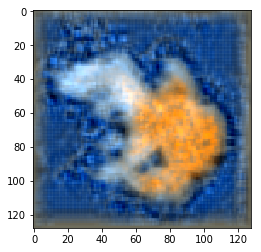

In [90]:
img = Image.open('goldfish.jpg')
img = transform(img)
img = img.unsqueeze(0)
autoencoder.eval() 
with torch.no_grad():
    out=autoencoder(img)
    
out = out.reshape((3,128,128))
outim = imshow(out)
plt.imshow(outim)
plt.show()

In [91]:
torch.save(autoencoder.module.state_dict(),"autoencoder.pth")

In [108]:
encoder = Net()

In [109]:
encoder.load_state_dict(torch.load("autoencoder.pth"))

<All keys matched successfully>

In [110]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

encoder = nn.Sequential(
            encoder.conv1,
            encoder.pool,
            encoder.conv2,
            encoder.pool,
            Flatten()
            )

In [111]:
encoder

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Flatten()
)

In [173]:
import random
subset_indices = []
for i in range(0,100):
    ran = random.randint(0,10000)
    subset_indices.append(ran)
subset = torch.utils.data.Subset(testset, subset_indices)
testloader_subset = torch.utils.data.DataLoader(subset, batch_size=1, num_workers=0, shuffle=True)

In [174]:
features = []
label = []
def testforward(net, x):
    with torch.no_grad():
        x = net[0](x)
        x = F.relu(x)
        x,_ = net[1](x)
        x = net[2](x)
        x = F.relu(x)
        x,_ = net[3](x)
        x = net[4](x)
    return x

for i, data in enumerate(testloader_subset, 0):
    inputs, labels = data
    labels = labels.tolist()[0]
    label.append(labels)
    with torch.no_grad():
        out=testforward(encoder, inputs)
        out=out.numpy()
        out=out.reshape(13456,)
        features.append(out)
    


In [175]:
from sklearn.cluster import KMeans 
kmeans_model = KMeans(n_clusters=5).fit(features)
model2 =  KMeans(n_clusters=10).fit(features)

In [176]:
result1 = kmeans_model.labels_
result2 = model2.labels_

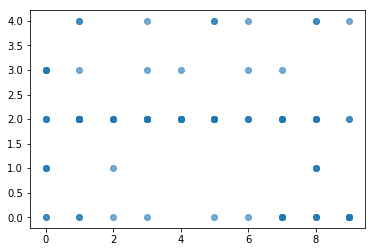

In [177]:
plt.scatter(label, result1, alpha=0.6)
plt.show()

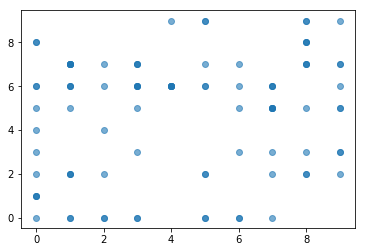

In [179]:
plt.scatter(label, result2, alpha = 0.6)
plt.show()